### Installation

`conda create -n ATACseq_SnapATAC python r-essentials jupyter pip pysam pybedtools -y`  
`pip install snaptools`  
`conda install -c bioconda bioconductor-rhdf5 bioconductor-rhdf5lib -y`  

### Preprocess

`SnapATAC_cusanovich2018subset_preprocess.ipynb`

###  Import packages

In [1]:
library(SnapATAC);
library(GenomicRanges);

Loading required package: Matrix
Loading required package: rhdf5
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:SnapATAC’:

    colMeans, colSums, rowMeans, rowSums

The following objects are masked from ‘package:Matrix’:

    colMeans, colSums, rowMeans, rowSums, which

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colMeans,
    colnames, colSums, dirname, do.call, duplicated, eval, evalq,
    Filter, Find, get, grep, grepl, intersect, is.unsorted, lapply,
    le

In [2]:
packageVersion("SnapATAC")

[1] ‘1.0.0’

### Obtain Feature Matrix

`time ./run_snaptools.sh`

output: 88mins46seconds

In [3]:
start_time <- Sys.time()

In [4]:
metadata <- read.table('../input/metadata.tsv',
                         header = TRUE,
                         stringsAsFactors=FALSE,quote="",row.names=1)

#### Barcode selection (keep all the cells)

In [5]:
x.sp = createSnap(
file="../input/cusanovich2018subset.snap",
sample="cusanovich2018subset",
do.par = TRUE,
num.cores=10)

Epoch: reading the barcode session ...


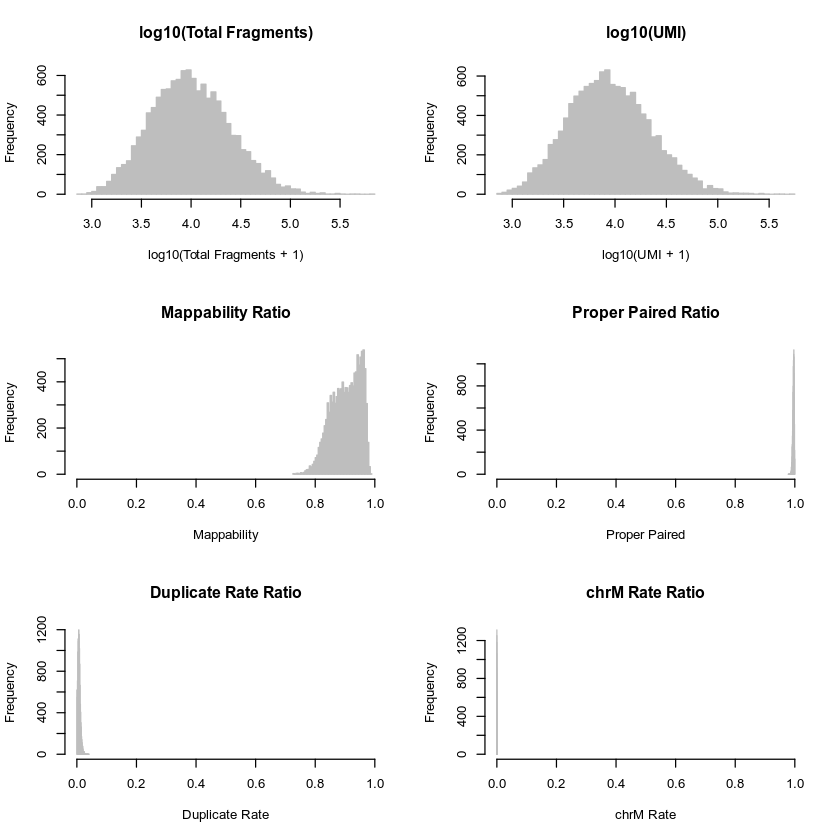

In [6]:
plotBarcode(
obj=x.sp, 
pdf.file.name=NULL, 
pdf.width=7, 
pdf.height=7, 
col="grey",
border="grey",
breaks=50
);

In [7]:
# # filter cells only using number of fragments and UMI with the following cutoffs
# x.sp = filterCells(
# obj=x.sp, 
# subset.names=c("fragment.num", "UMI"),
# low.thresholds=c(1000,1000),
# high.thresholds=c(Inf, Inf)
# );

#### Bin size selection (SnapATAC)

In [8]:
# show what bin sizes exist in atac_v1_adult_brain_fresh_5k.snap file
showBinSizes("../input/cusanovich2018subset.snap");
x.sp = addBmatToSnap(x.sp, bin.size=5000, num.cores=10);

[1] 5000

Epoch: reading cell-bin count matrix session ...


In [9]:
x.sp;

number of barcodes: 12178
number of bins: 545170
number of genes: 0
number of peaks: 0

In [10]:
summarySnap(x.sp);

Total  number of barcodes: 12178
Median number of sequencing fragments: 9478.5
Median number of uniquely mapped fragments: 8424
Median number of mappability ratio: 0.91
Median number of properly paired ratio: 1
Median number of duplicate ratio: 0.01
Median number of chrM ratio: 0
Median number of unique molecules (UMI): 8424


#### Fragments-in-promoter ratio (Keep all cells and skip this step)

#### Matrix binarization (SnapATAC)

In [11]:
x.sp = makeBinary(x.sp, mat="bmat");

####  Bin filtration (SnapATAC)

In [12]:
# system("wget http://mitra.stanford.edu/kundaje/akundaje/release/blacklists/mm9-mouse/mm9-blacklist.bed.gz")

In [13]:
# black_list = read.table('mm9-blacklist.bed.gz')
# black_list.gr = GRanges(black_list[,1], IRanges(black_list[,2], black_list[,3]));
# idy1 = queryHits(findOverlaps(x.sp@feature, black_list.gr));
idy2 = grep("chrM|random", x.sp@feature);
# idy = unique(c(idy1, idy2));
x.sp = x.sp[,-idy2, mat="bmat"];

In [14]:
x.sp

number of barcodes: 12178
number of bins: 530988
number of genes: 0
number of peaks: 0

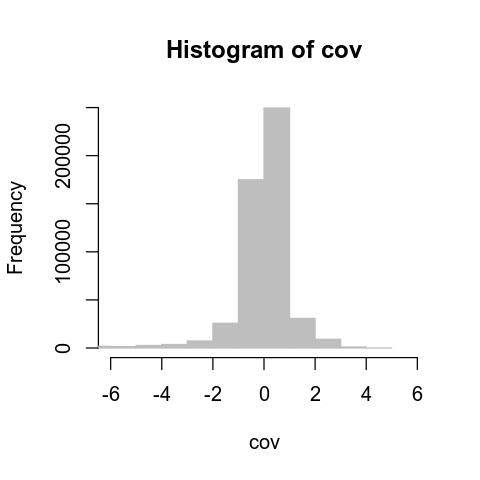

In [15]:
options(repr.plot.width=4, repr.plot.height=4)
plotBinCoverage(
    x.sp,
    pdf.file.name=NULL,
    col="grey",
    border="grey",
    breaks=10,
    xlim=c(-6,6)
    );

In [16]:
x.sp = filterBins(
x.sp,
low.threshold=-2,
high.threshold=2,
mat="bmat"
);
x.sp

number of barcodes: 12178
number of bins: 480884
number of genes: 0
number of peaks: 0

#### Jaccard matrix 

In [17]:
### the function failed when do.par=TRUE
x.sp = runJaccard(
obj = x.sp,
tmp.folder=tempdir(),
mat = "bmat",
max.var=2000,
ncell.chunk=1000,
do.par=FALSE,
num.cores=10,
seed.use=10
);

#### Normalization

In [18]:
### the function failed when do.par=TRUE
x.sp = runNormJaccard(
    obj = x.sp,
    tmp.folder=tempdir(),
    ncell.chunk=1000,
    method="normOVE",
    row.center=TRUE,
    row.scale=TRUE,
    low.threshold=-5,
    high.threshold=5,
    do.par=FALSE,
    num.cores=10,
    seed.use=10
    );

#### Linear Dimentionality Reduction

In [19]:
x.sp = runDimReduct(
    x.sp,
    pc.num=50,
    input.mat="jmat",
    method="svd",
    center=TRUE,
    scale=FALSE,
    seed.use=10
    );

#### Determine statistically significant principal components (SnapATAC)

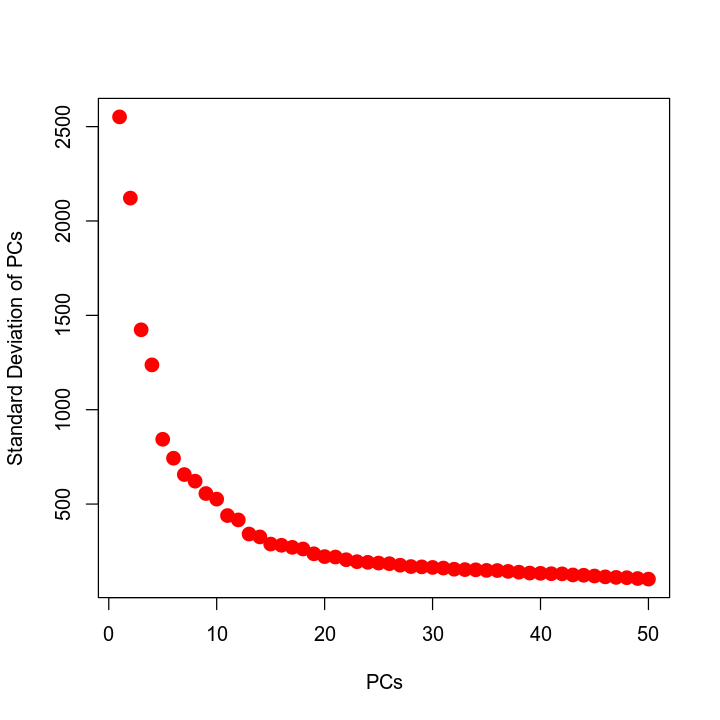

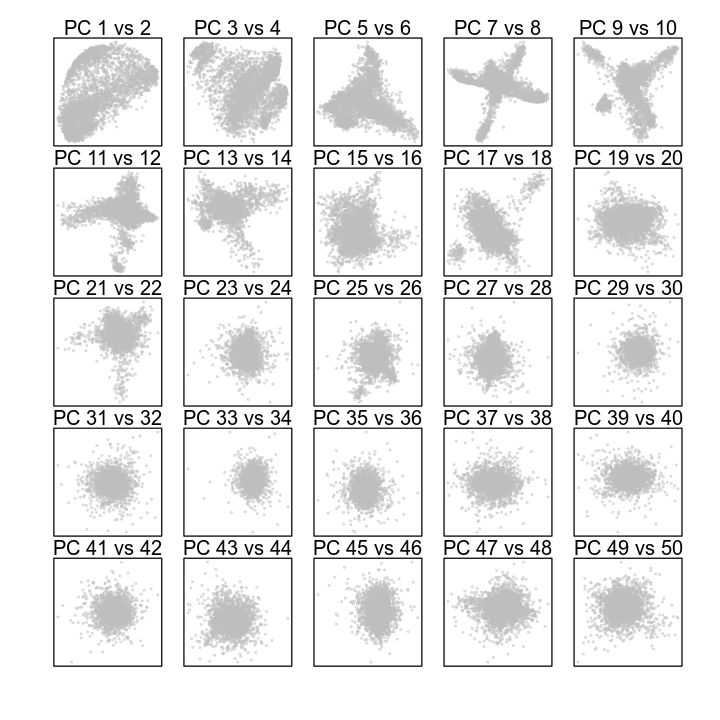

In [20]:
options(repr.plot.width=6, repr.plot.height=6)
plotDimReductElbow(
    obj=x.sp, 
    point.size=1.5,
    point.shape=19,
    point.color="red",
    point.alpha=1,
    pdf.file.name=NULL,
    pdf.height=7,
    pdf.width=7,
    labs.title="PCA Elbow plot",
    labs.subtitle=NULL
    );
plotDimReductPW(
    obj=x.sp, 
    pca.dims=1:50,
    point.size=0.3,
    point.color="grey",
    point.shape=19,
    point.alpha=0.6,
    down.sample=5000,
    pdf.file.name=NULL, 
    pdf.height=7, 
    pdf.width=7
    );

In [21]:
str(x.sp)

Formal class 'snap' [package "SnapATAC"] with 16 slots
  ..@ des     : chr(0) 
  ..@ barcode : chr [1:12178] "AGCGATAGAACGAATTCGAAGCCTACGACCTATCCT" "AGCGATAGAACGAATTCGAAGCCTACGATATAGCCT" "AGCGATAGAACGAATTCGACTGAGCGACTATAGCCT" "AGCGATAGAACGAATTCGCAATGAGTCCCAGGACGT" ...
  ..@ file    : chr [1:12178] "/data/pinello/PROJECTS/2019_03_scATAC/Github_supp/Cusanovich_2018_subset/input/cusanovich2018subset.snap" "/data/pinello/PROJECTS/2019_03_scATAC/Github_supp/Cusanovich_2018_subset/input/cusanovich2018subset.snap" "/data/pinello/PROJECTS/2019_03_scATAC/Github_supp/Cusanovich_2018_subset/input/cusanovich2018subset.snap" "/data/pinello/PROJECTS/2019_03_scATAC/Github_supp/Cusanovich_2018_subset/input/cusanovich2018subset.snap" ...
  ..@ sample  : chr [1:12178] "cusanovich2018subset" "cusanovich2018subset" "cusanovich2018subset" "cusanovich2018subset" ...
  ..@ metaData:'data.frame':	12178 obs. of  6 variables:
  .. ..$ barcode: Factor w/ 12178 levels "AGCGATAGAACGAATTCGAAGCCTACGACCTATCCT",..: 1 

In [22]:
end_time <- Sys.time()
end_time - start_time

Time difference of 2.777335 mins

In [23]:
dim(x.sp@smat@dmat)

[1] 12178    50

In [24]:
df_out = data.frame(t(x.sp@smat@dmat)[1:25,],row.names = sprintf("PC_%s",seq(1:25)))
colnames(df_out) = as.character(x.sp@metaData$barcode)

In [25]:
dim(df_out)
df_out[1:5,1:5]

[1]    25 12178

,AGCGATAGAACGAATTCGAAGCCTACGACCTATCCT,AGCGATAGAACGAATTCGAAGCCTACGATATAGCCT,AGCGATAGAACGAATTCGACTGAGCGACTATAGCCT,AGCGATAGAACGAATTCGCAATGAGTCCCAGGACGT,AGCGATAGAACGAATTCGCCTCCGACGGGTACTGAC
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
PC_1,0.009727967,-0.0143507681,-0.007119295,-0.009664105,-0.013958460
PC_2,0.012343391,-0.0001225366,0.016334048,0.014440138,-0.001005590
PC_3,-0.006833390,-0.0045055631,0.006145413,0.007618424,-0.005695077
PC_4,-0.013635861,0.0011786312,0.002875357,0.003996616,0.002954883
PC_5,-0.004097849,0.0044043223,0.001720687,-0.006414152,0.003024333


In [26]:
sum(colnames(df_out) == rownames(metadata))

[1] 0

In [27]:
df_out = df_out[rownames(metadata)]
dim(df_out)
df_out[1:5,1:5]

[1]    25 12178

,TCCGCGAACTAACTAGGTTGCTACGGTCATAGAGGC,TCCGCGAAAGGTCAGCTTTGCGGATAGTGTACTGAC,ATTACTCGTTGCCGTAGGCTTAATCTTGTATAGCCT,TCCGCGAAACCAGGCGCAAAGCTAGGTTGTACTGAC,ATTCAGAATCGTAGCATCGCGCAATGACCCTATCCT
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
PC_1,0.010306718,0.010859330,-0.0065664741,-0.0048671154,0.002565581
PC_2,0.012649021,0.011959219,-0.0015252364,0.0171450490,0.009749403
PC_3,-0.004062025,-0.007147373,0.0027505337,-0.0008097324,-0.002354155
PC_4,-0.011874773,-0.012032649,-0.0004392902,-0.0010104604,-0.007155385
PC_5,-0.007720549,-0.009288400,0.0096191373,0.0028094440,-0.004901822


In [28]:
sum(colnames(df_out) == rownames(metadata))

[1] 12178

In [29]:
saveRDS(df_out, file = '../output/feature_matrices/FM_SnapATAC_cusanovich2018_subset_no_blacklist_filtering.rds')

### Downstream Analysis

#### KNN Graph Construction (SnapATAC)

In [30]:
x.sp = runKNN(
    obj=x.sp,
    pca.dims=1:30,
    weight.by.sd=FALSE,
    k=15
    );

#### Clustering (SnapATAC)

In [31]:
x.sp = runCluster(
    obj=x.sp,
    tmp.folder=tempdir(),
    louvain.lib="R-igraph",
    path.to.snaptools=NULL,
    seed.use=10
    );

#### Non-linear dimentionality reduction (SnapATAC)

In [32]:
x.sp = runViz(
    obj=x.sp, 
    tmp.folder=tempdir(),
    dims=2,
    pca.dims=1:25, 
    weight.by.sd=FALSE,
    method="Rtsne",
    fast_tsne_path=NULL,
    Y.init=NULL,
    seed.use=10,
    num.cores=5
    );

x.sp = runViz(
    obj=x.sp, 
    tmp.folder=tempdir(),
    dims=2,
    pca.dims=1:25, 
    weight.by.sd=FALSE,
    method="umap",
    fast_tsne_path=NULL,
    Y.init=NULL,
    seed.use=10,
    num.cores=5
    );

In [33]:
x.sp@sample = metadata[as.character(x.sp@metaData$barcode),'label']

#### Visulization (SnapATAC)

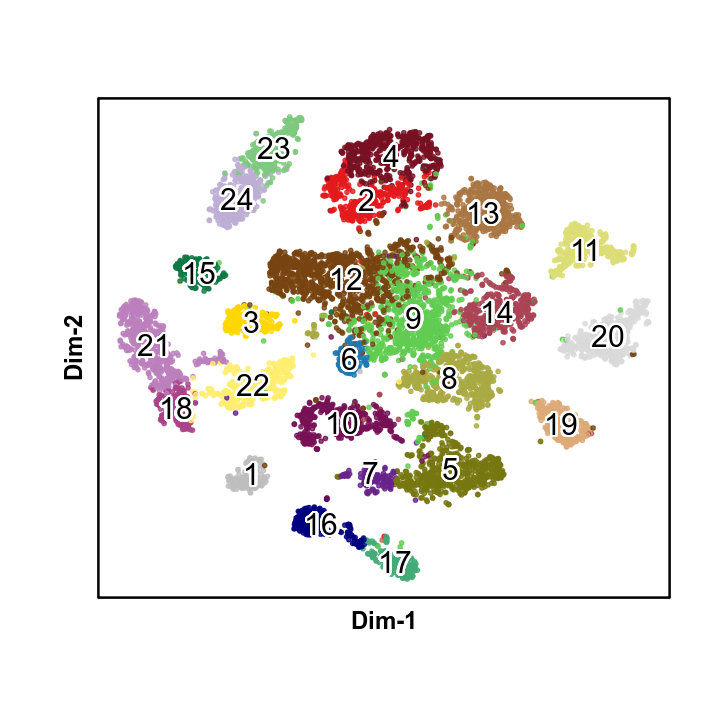

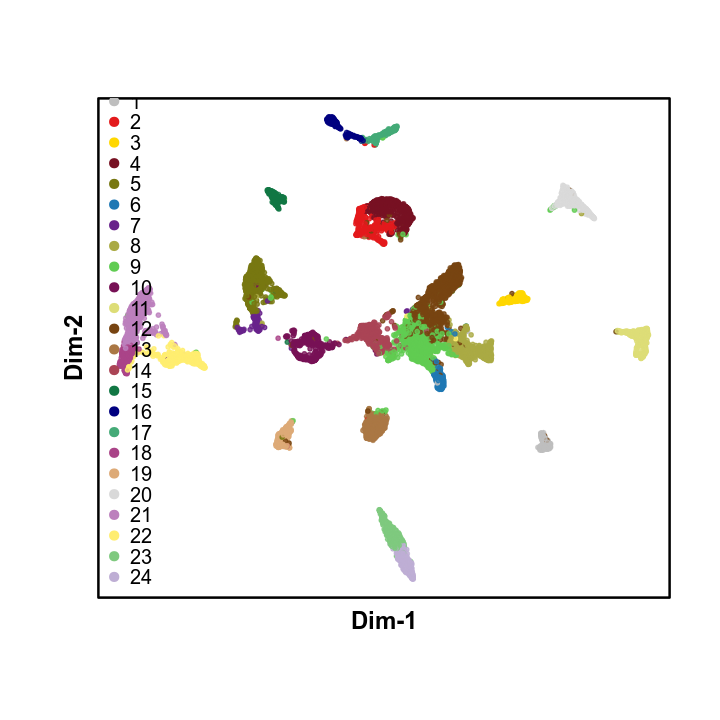

In [34]:
plotViz(
    obj=x.sp, 
    method="tsne", 
    point.size=0.5, 
    point.shape=19, 
    point.alpha=0.8, 
    point.color="cluster", 
    text.add=TRUE,
    text.size=1.5,
    text.color="black",
    text.halo.add=TRUE,
    text.halo.color="white",
    text.halo.width=0.2,
    down.sample=10000,
    pdf.file.name=NULL,
    pdf.width=7, 
    pdf.height=7
    );
plotViz(
    obj=x.sp, 
    method="umap", 
    point.size=0.5, 
    point.shape=19, 
    point.alpha=0.8, 
    point.color="cluster", 
    text.add=FALSE,
    text.size=1.5,
    text.color="black",
    text.halo.add=TRUE,
    text.halo.color="white",
    text.halo.width=0.2,
    down.sample=10000,
    legend.add=TRUE,
    pdf.file.name=NULL,
    pdf.width=7, 
    pdf.height=7
    );

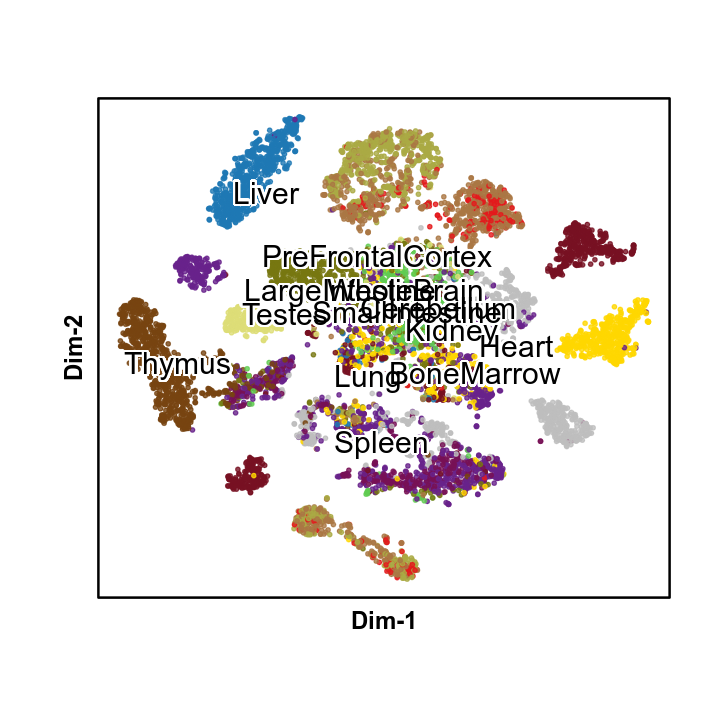

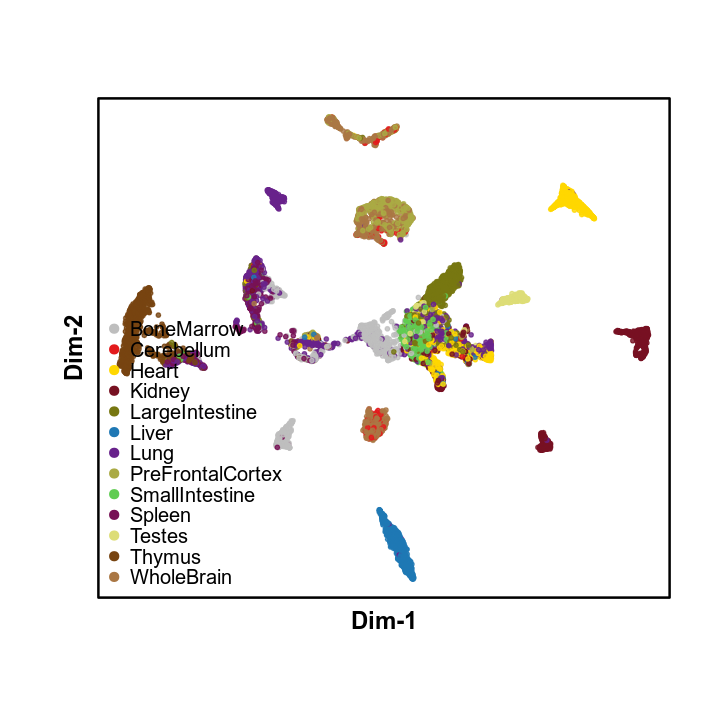

In [35]:
plotViz(
    obj=x.sp, 
    method="tsne", 
    point.size=0.5, 
    point.shape=19, 
    point.alpha=0.8, 
    point.color="sample", 
    text.add=TRUE,
    text.size=1.5,
    text.color="black",
    text.halo.add=TRUE,
    text.halo.color="white",
    text.halo.width=0.2,
    down.sample=10000,
    pdf.file.name=NULL,
    pdf.width=5, 
    pdf.height=5
    );
plotViz(
    obj=x.sp, 
    method="umap", 
    point.size=0.5, 
    point.shape=19, 
    point.alpha=0.8, 
    point.color="sample", 
    text.add=FALSE,
    text.size=1.5,
    text.color="black",
    text.halo.add=TRUE,
    text.halo.color="white",
    text.halo.width=0.2,
    down.sample=10000,
    legend.add=TRUE,
    pdf.file.name=NULL,
    pdf.width=5, 
    pdf.height=5
    );

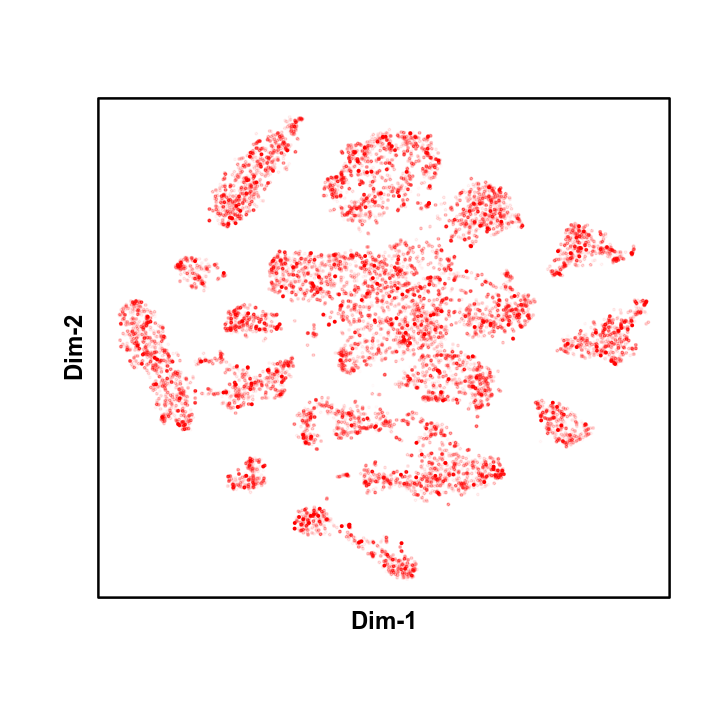

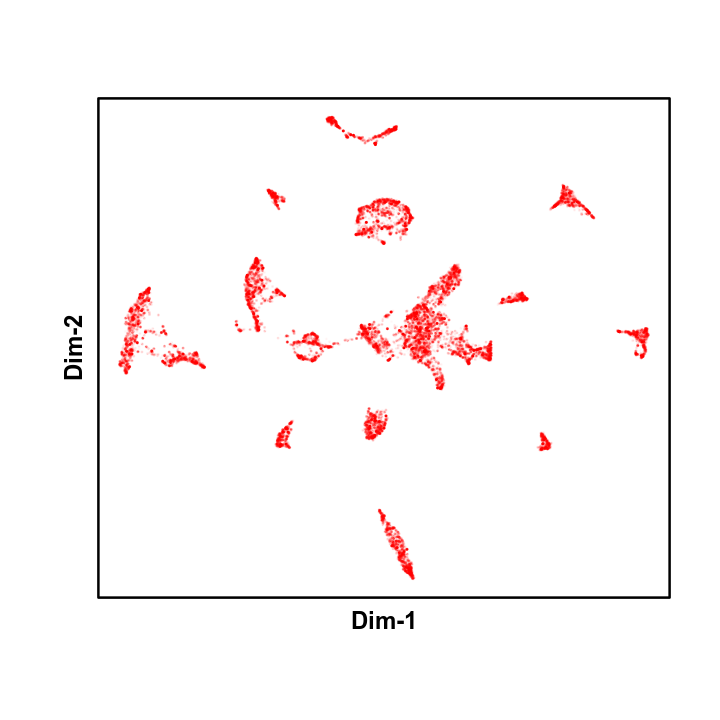

In [36]:
feature.value = SnapATAC::rowSums(x.sp@bmat);
feature.value = pmin(feature.value, quantile(feature.value, 0.99));
feature.value = pmax(feature.value, 0);
feature.value = (feature.value-min(feature.value))/(max(feature.value)-min(feature.value));
PlotFeatureSingle(
    obj=x.sp, 
    feature.value=feature.value,
    method="tsne", 
    point.size=0.3, 
    point.shape=19, 
    point.color="red", 
    down.sample=10000, 
    pdf.file.name=NULL, 
    pdf.width=7, 
    pdf.height==7
    );
PlotFeatureSingle(
    obj=x.sp, 
    feature.value=feature.value,
    method="umap", 
    point.size=0.2, 
    point.shape=19, 
    point.color="red", 
    down.sample=10000, 
    pdf.file.name=NULL, 
    pdf.width=7, 
    pdf.height==7
    );

In [37]:
sessionInfo()

R version 3.5.1 (2018-07-02)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS: /data/pinello/SHARED_SOFTWARE/anaconda3/envs/ATACseq_SnapATAC_py37/lib/R/lib/libRblas.so
LAPACK: /data/pinello/SHARED_SOFTWARE/anaconda3/envs/ATACseq_SnapATAC_py37/lib/R/lib/libRlapack.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
[1] GenomicRanges_1.34.0 GenomeInfoDb_1.18.2  IRanges_2.16.0      
[4] S4Vectors_0.20.1     BiocGenerics_0.28.0  SnapATAC_1.0.0      
[7] rhdf5_2.26.2     

In [40]:
save.image(file = '../../ouput/SnapATAC_cusanovich2018_subset_no_blacklist_filtering.RData')

Warning message in gzfile(file, "wb"):
“cannot open compressed file '../../ouput/SnapATAC_cusanovich2018_subset_no_blacklist_filtering.RDataTmp', probable reason 'No such file or directory'”

ERROR: Error in gzfile(file, "wb"): cannot open the connection


Warning message in file.remove(outfile):
“cannot remove file '../../ouput/SnapATAC_cusanovich2018_subset_no_blacklist_filtering.RDataTmp', reason 'No such file or directory'”